# Devoping a Sentiment Analysis Model
- Trying out methods to estimate an articles level of positive or negative sentiment towards the subject
- Training using yelp and movie reviews

In [458]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import movie_reviews, stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import time, string
import matplotlib.pyplot as plt
import seaborn as sns

In [623]:
s = """Why it rocks:
While movies like Toy Story revolutionized the visual aspect of animation, Shrek on the other hand marked an important point in the structure and storytelling aspect in animation as it stepped away from the classic tropes and clichés used in animation so far while introducing"""

In [625]:

X = bow_transformer.transform([s])

In [627]:
bow_transformer.vocabulary_.get("movie")

4671

In [633]:
tfidf_transformer.idf_[4671]

1.2716526455422215

In [459]:
reviews = [[file.split("/")[0], file] for file in movie_reviews.fileids()]
df = pd.DataFrame(reviews, columns=["label", "fileid"])

In [999]:
# Preloading stopwords into set to improve speed by 10X
stopSet = set(stopwords.words("english"))
puncSet = set(list(string.punctuation) + ["\n", ""])

cleanword = lambda word: ((word not in puncSet) and (word.isalpha()) and (len(word)>1))

def preprocess(words, string=False):
    if(type(words) == str):
        words = re.sub(r"\s+", " ", words)
        words = re.sub(r"[^a-zA-Z\s]", "", words)
        words = words.split(" ")
    
    clean_mess = [w.lower() for w in words if w.lower() not in stopSet and cleanword(w)]
    if(string):
        return " ".join(clean_mess)
    else:
        return clean_mess


In [964]:
print(len(movie_reviews.words("neg/cv000_29416.txt")))
len(preprocess(movie_reviews.words("neg/cv000_29416.txt")))

879


324

## Evaluating using tf-idf on movie reviews

In [589]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [1000]:
%%time

# Getting word counts using all documents
bow_transformer = CountVectorizer(analyzer=preprocess, min_df=3, max_features=8000).fit(df.fileid.apply(movie_reviews.raw))
print(f"Bag of works vocab size {len(bow_transformer.vocabulary_)}")

# Getting the term frequency for each document
reviews_bow = bow_transformer.transform(df.fileid.apply(movie_reviews.raw))
print(reviews_bow.shape)

# 
tfidf_transformer = TfidfTransformer().fit(reviews_bow)
reviews_tfidf = tfidf_transformer.transform(reviews_bow)

sentiment_detect_model = MultinomialNB().fit(reviews_tfidf, df['label'])

len(bow_transformer.vocabulary_)

Bag of works vocab size 8000
(2000, 8000)
CPU times: total: 2.3 s
Wall time: 2.3 s


8000

In [1001]:
movie_train, movie_test, label_train, label_test = train_test_split(df['fileid'], df['label'], test_size=0.25, random_state=101)

In [659]:
%%time
pipeline = Pipeline([('bow', CountVectorizer(analyzer=preprocess, min_df=3, max_features=16000)), ('tfidf', TfidfTransformer()), ('classifier', MultinomialNB())])

pipeline.fit(movie_train.apply(movie_reviews.raw), label_train)
predictions = pipeline.predict(movie_test.apply(movie_reviews.raw))

print(confusion_matrix(label_test, predictions))
print (classification_report(label_test, predictions))

[[215  26]
 [ 45 214]]
              precision    recall  f1-score   support

         neg       0.83      0.89      0.86       241
         pos       0.89      0.83      0.86       259

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500

CPU times: total: 1.42 s
Wall time: 1.41 s


In [543]:
probs = pipeline.predict_proba(df.fileid.apply(movie_reviews.raw))
df["class"] = pipeline.predict(df.fileid.apply(movie_reviews.raw))
df[["negative", "positive"]] = probs

## Evaluating using TF-IDF on yelp reviews

In [827]:
yelp = pd.read_csv("yelp.csv")
yelp['label'] = yelp.stars.apply(lambda x: 'pos' if x > 2 else 'neg')
yelp = yelp[["text", "stars", "label", "type", "cool", "useful", "funny"]]

In [828]:
ypipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocess, min_df=3)), 
    ('tfidf', TfidfTransformer()), 
    ('classifier', MultinomialNB())])


yelp_train, yelp_test, label_train, label_test = train_test_split(yelp['text'], yelp['label'], test_size=0.3, random_state=17)

ypipeline.fit(yelp_train, label_train)

predictions = ypipeline.predict(yelp_test)

In [829]:
print(confusion_matrix(label_test, predictions))
print (classification_report(label_test, predictions))

[[   4  486]
 [   0 2510]]
              precision    recall  f1-score   support

         neg       1.00      0.01      0.02       490
         pos       0.84      1.00      0.91      2510

    accuracy                           0.84      3000
   macro avg       0.92      0.50      0.46      3000
weighted avg       0.86      0.84      0.77      3000



In [958]:
ypipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocess, min_df=3, max_df=1.0, max_features=6000)), 
    ('tfidf', TfidfTransformer()), 
    ('classifier', MultinomialNB())])

syelp = yelp[(yelp.stars > 4) | (yelp.stars < 3)]
# syelp=yelp

ypipeline.fit(syelp.text, syelp.label)
yelp["class"] = ypipeline.predict(yelp.text)
yelp[["negative", "positive"]] = ypipeline.predict_proba(yelp.text)

In [959]:
print(confusion_matrix(yelp.label, yelp["class"]))
print (classification_report(yelp.label, yelp["class"]))
# print(mean_absolute_error(yelp.stars, syelp["class"]))
print(yelp.corr().stars["positive"])

[[1215  461]
 [ 355 7969]]
              precision    recall  f1-score   support

         neg       0.77      0.72      0.75      1676
         pos       0.95      0.96      0.95      8324

    accuracy                           0.92     10000
   macro avg       0.86      0.84      0.85     10000
weighted avg       0.92      0.92      0.92     10000

0.7752080821701111


C:\Users\jonat\AppData\Local\Temp\ipykernel_15632\4138432084.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(yelp.corr().stars["positive"])


<AxesSubplot: xlabel='stars', ylabel='positive'>

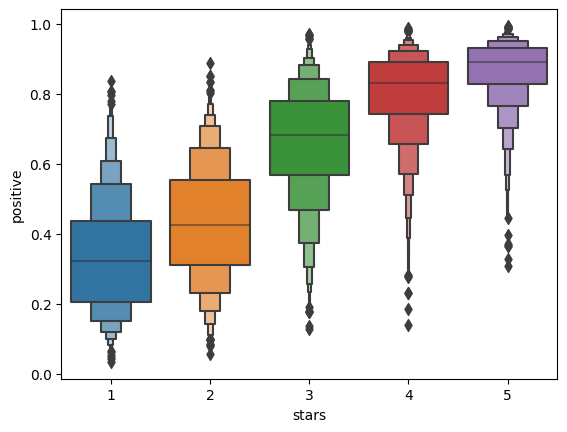

In [960]:
sns.boxenplot(yelp, x="stars", y="positive")

<AxesSubplot: xlabel='positive', ylabel='Count'>

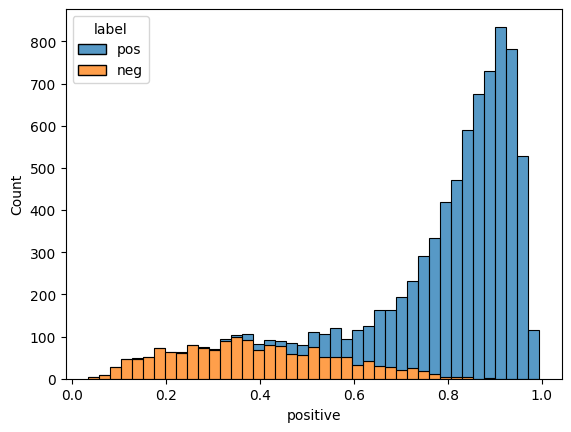

In [961]:
sns.histplot(yelp[yelp.stars!=3], x="positive", hue="label", multiple="stack")

In [962]:
yelp[(yelp.positive < 0.4) & (yelp.stars>=5)]

,text,stars,label,type,cool,useful,funny,class,negative,positive
3448,I was there last week with my sisters and whil...,5,pos,review,1,2,0,neg,0.635657,0.364343
5637,I'm giving them a 5 star review for how they h...,5,pos,review,3,2,0,neg,0.692568,0.307432
6318,Since I have ranted recently on poor customer ...,5,pos,review,2,2,3,neg,0.601948,0.398052
7903,"First, I'm sorry this review is lengthy, but i...",5,pos,review,2,2,1,neg,0.671153,0.328847
8319,"So, my friend and I went first to Yasu because...",5,pos,review,0,0,0,neg,0.629237,0.370763
9636,OK OK... as a Proud Italian I hope my momma do...,5,pos,review,4,3,3,neg,0.634665,0.365335


## SAVING MODEL

In [900]:
import pickle
with open("sentiment_pipeline.pickle", 'wb') as fileo:
    pickle.dump(ypipeline, fileo)

## Evaluating on news articles

In [1006]:
filer = open("sentiment_pipeline.pickle", "rb")
pipeline2 = pickle.load(filer)

In [1008]:
tesla = pd.read_csv('reuters_tesla.csv')
tesla = tesla[["title", "description", "article"]]

In [1020]:
tesla['label'] = pipeline2.predict(tesla.description)
tesla[['negative', 'postive']] = pipeline2.predict_proba(tesla.description)

In [1025]:
tesla.head()

,title,description,article,label,negative,postive
0,Fisker to sell electric SUV in India with view...,U.S. startup Fisker Inc will begin selling its...,Summary\r\nCompanies\r\nFisker to launch brand...,pos,0.375429,0.624571
1,"GM, Hertz make deal to deploy up to 175,000 EVs",Rental car company Hertz Global Holdings plans...,Sept 20 (Reuters) - (This Sept. 20 story was o...,pos,0.372046,0.627954
2,Tesla countersues California agency behind rac...,Tesla Inc on Thursday countersued the Californ...,Companies\r\nTesla Inc\r\nFollow\r\nSept 22 (R...,pos,0.388480,0.611520
3,"LG Energy inks cobalt, lithium supply deals wi...",South Korean battery maker LG Energy Solution ...,"SEOUL, Sept 23 (Reuters) - South Korean batter...",pos,0.394317,0.605683
4,Wall Street ends down for third day as growth ...,Major Wall Street indexes ended lower on Thurs...,Summary\r\nCompanies\r\nTech stocks down in af...,neg,0.547565,0.452435


In [1029]:
tesla.description.iloc[4]

"Major Wall Street indexes ended lower on Thursday, falling for a third straight session as investors reacted to the Federal Reserve's latest aggressive move to rein in inflation by selling growth stocks, including technology companies."

## Other model?

In [131]:
%%time
positive_words = preprocess(nltk.corpus.movie_reviews.words(categories=["pos"]), string=False)
negative_words = preprocess(nltk.corpus.movie_reviews.words(categories=["neg"]), string=False)
print(f"postive: {len(positive_words)} \nnegative: {len(negative_words)}")

postive: 371560 
negative: 329983
CPU times: total: 2.25 s
Wall time: 2.21 s


In [96]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

In [138]:
%%time
common_set = set(positive_words).intersection(set(negative_words))
for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

CPU times: total: 93.8 ms
Wall time: 93 ms


## Evaluating Pretrained VADER Model

In [300]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as Vader
# sia = SentimentIntensityAnalyzer()
sia = Vader()
# example = movie_reviews.words("neg/cv000_29416.txt")
# sn = preprocess(example)
# sia.polarity_scores(sn)

In [366]:
sia.polarity_scores("good BAD")

{'neg': 0.593, 'neu': 0.0, 'pos': 0.407, 'compound': -0.3254}

In [367]:
df['compound'] = df.fileid.apply(lambda x: sia.polarity_scores(movie_reviews.raw(x))['compound'])
df["compound_alpha"] = df["compound"].apply(lambda x: 'pos' if x > 0 else 'neg')
df.groupby("label").describe().T

label                   neg          pos
compound count  1000.000000  1000.000000
         mean      0.107110     0.646057
         std       0.904130     0.702314
         min      -0.999700    -0.999600
         25%      -0.954550     0.902900
         50%       0.682050     0.990900
         75%       0.982025     0.997225
         max       0.999600     0.999900

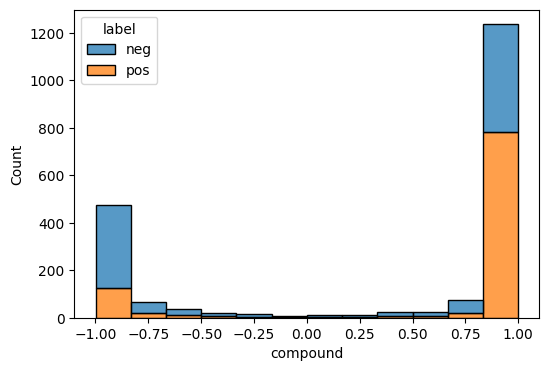

In [329]:
g = sns.histplot(df, x="compound", hue="label", multiple="stack").figure.set_size_inches(w=6, h=4);

## Training a sentiment analyser

In [ ]:
import nltk